# Analisis exploratorio

### Links
- [Dataset](https://eval.ai/web/challenges/challenge-page/1721/overview)
- [SentenceTransformers](https://www.sbert.net/)
- [UMAP](https://umap-learn.readthedocs.io/en/latest)
- [Plotting UMAP results](https://umap-learn.readthedocs.io/en/latest/plotting.html)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.append('../../src')

from matplotlib import pyplot as plt
import seaborn  as sns

import numpy  as np
import pandas as pd
import torch

import logging
import random

import data  as dt
import model as ml
import util  as ut
import pytorch_common.util as pu

## Setup

Se configura el default logger para que la consola sea el output y loguee mensajes a partir del nivel INFO.

In [ ]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

Chequeamos si se detecta la GPU:

In [ ]:
torch.cuda.is_available()

True

In [ ]:
torch.__version__

'1.12.1+cu116'

Por defecto usamos GPU. De no existir este hardware, el fallback es CPU:

In [ ]:
pu.set_device_name('gpu')

logging.info(pu.get_device())

2022-09-18 12:02:45,608 - INFO - cuda:0


In [ ]:
torch.cuda.get_arch_list()

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']

Fijamos la semilla:

In [ ]:
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)

In [ ]:
set_seed(42)

Parametros de la notebook:

In [ ]:
DATASET_PATH = '../../datasets/fashion-outfits'

### Funciones helper

In [ ]:
def plot_columns(df, x_col, y_col, title):
    plt.figure(figsize=(8,5))
    ax = sns.barplot(x=x_col, y=y_col, data=df,  orient = 'h', order = df[y_col].values)
    ax.set(xlabel=x_col)
    ax.set(ylabel=y_col)
    ax.set(yticklabels=[])
    ax.set_title(title)
    plt.show()

    
branch_count = lambda df: ut.group_by_count(df, 'branch_seq', 'id').rename(columns={'id': 'branch_count'})

def plot_branch_count(df):
    plot_columns(
        df, 
        y_col = 'branch_seq', 
        x_col = 'branch_count', 
        title = 'Cantida de productos por rama del arbol de categorias'
    )
    
def plot_title(df, column, title):
    df = df.sort_values([column], ascending=False)
    plt.figure(figsize=(8,4))
    ax = sns.barplot(x=column, y='title', data=df)
    ax.set(ylabel=None)
    ax.set(yticklabels=[])
    ax.set_title(title)
    plt.show()

In [ ]:
def append(hash_table, key, value):
    if key not in hash_table:
        hash_table[key] = []
    hash_table[key].append(value)

def branches_to_data_frame(df, column, separator='~', null_value=None):
    count_df = df[column].value_counts()

    branches = [[v.strip() for v in value.split(separator)] for value in count_df.index]
    n_levels = max([len(b) for b in branches])
    
    data = {}
    for branch in branches:
        last_level = 0
        for level, value in enumerate(branch):
            last_level = level
            append(data, f'level_{level}', '' if value == null_value else value)

    data = pd.DataFrame(data) \
        .dropna(how='all', axis=1) \
        .dropna(axis=0)
    data['count'] = count_df.values.tolist()
    return data

## Preparar dataset

In [ ]:
dataset = pd.read_csv(f'{DATASET_PATH}/all.csv')
dataset.head()

id 
 family 
 category 
 sub_category 
 description 
 highlights 
 brand 
 gender 
 materials 
 branch 
 branch_seq 
 
 
 
 
 0 
 17073270 
 clothing 
 knitwear 
 cardi-coats 
 x The Beatles intarsia-knit coat 
 [black/white, organic cotton, mix print, intar... 
 stella mccartney 
 unisex 
 ['Cotton'] 
 clothing~knitwear~cardi-coats 
 0 
 
 
 1 
 17674562 
 clothing 
 knitwear 
 cardi-coats 
 cashmere-blend long belted cardigan 
 [plum purple, cashmere blend, wrap design, sle... 
 extreme cashmere 
 unisex 
 ['Spandex/Elastane' 'Nylon' 'Cashmere'] 
 clothing~knitwear~cardi-coats 
 0 
 
 
 2 
 17678603 
 clothing 
 knitwear 
 cardi-coats 
 cashmere-blend long belted cardigan 
 [blue, cashmere blend, wrap design, sleeveless... 
 extreme cashmere 
 unisex 
 ['Spandex/Elastane' 'Cashmere' 'Nylon'] 
 clothing~knitwear~cardi-coats 
 0 
 
 
 3 
 17179699 
 clothing 
 knitwear 
 cardi-coats 
 long cashmere cardigan 
 [light pink, stretch-cashmere blend, fine knit... 
 extreme cashmere 
 unisex 
 ['Nylon' 'Spandex/Elastane' 'Cashmere'] 
 clothing~knitwear~cardi-coats 
 0 
 
 
 4 
 17372698 
 clothing 
 knitwear 
 cardi-coats 
 cable knit oversized shawl cardigan 
 [black , virgin wool , cable knit, draped desi... 
 les hommes 
 men 
 ['Virgin Wool'] 
 clothing~knitwear~cardi-coats 
 0

# Visualización de categorias de productos

La columna branch representa la rama del arbol de categorias donde se encuentra un producto.

In [ ]:
branches = dataset['branch']
branches.head()

0    clothing~knitwear~cardi-coats
1    clothing~knitwear~cardi-coats
2    clothing~knitwear~cardi-coats
3    clothing~knitwear~cardi-coats
4    clothing~knitwear~cardi-coats
Name: branch, dtype: object

**Observaciones**

* Se peude apreciar que cada producto se encuetra dentro de una categoria hoja dentro del un arbolde categorias.
* A su vez pertenese a una categoria padre.
* El arbol de categoroas parece tener unicamente 3 niveles.

Creamos un data frame con todas las ramas/arista del arbol de categorias, Luiego graficamos la jerarquia de categorias, especificando la cantidad de productos por cada categoria:

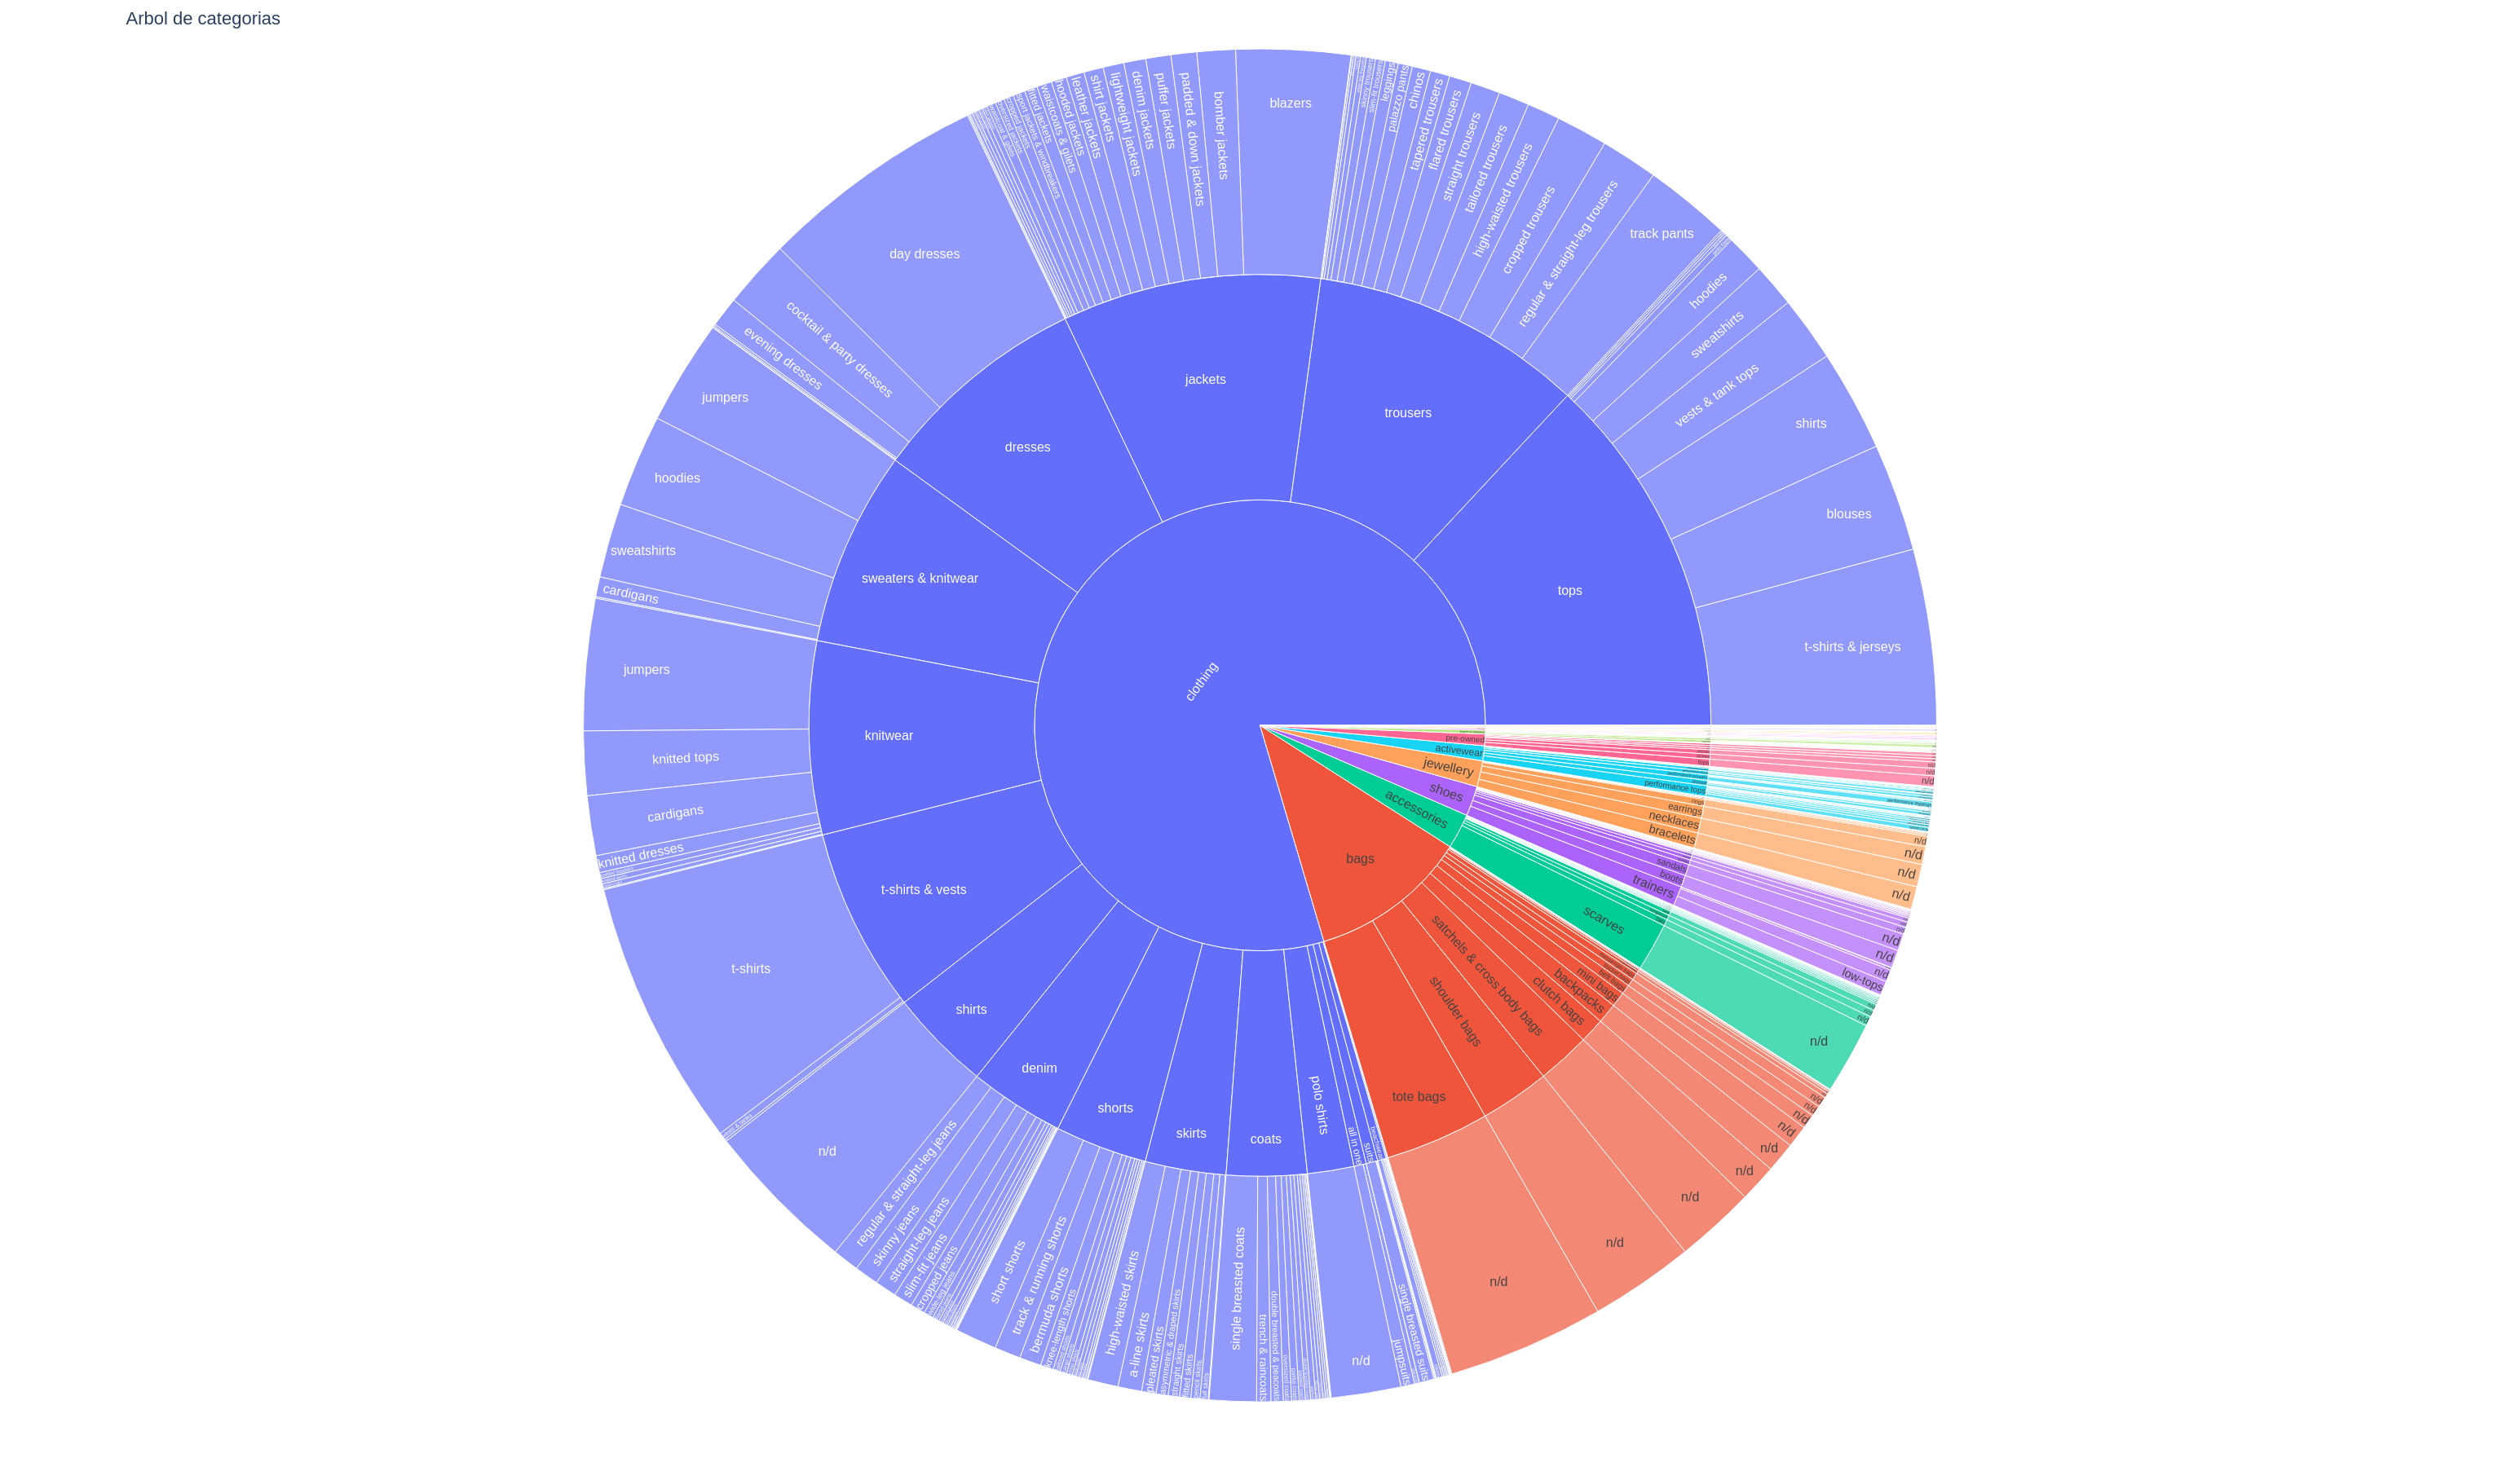

In [ ]:
dt.plot_tree(
    df    = branches_to_data_frame(dataset, 'branch'), 
    title = 'Arbol de categorias'
)

## Cantidad de productos por rama

<Figure size 800x500 with 1 Axes>

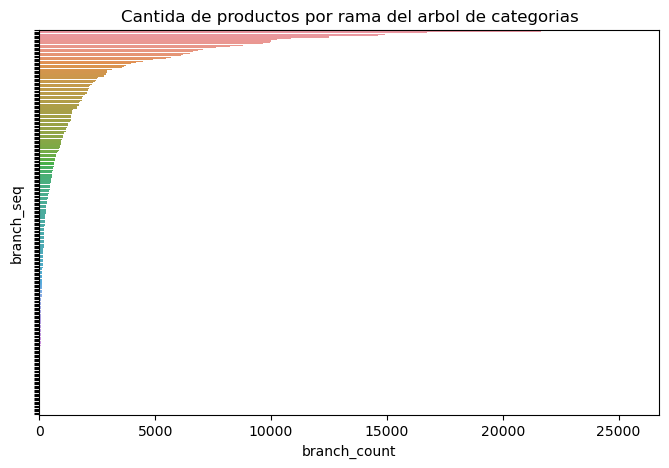

In [ ]:
plot_branch_count(branch_count(dataset))

## Cluster de categorias

A continacion se generan embeddings para cada categoria y título. Luego, se reduce la dimensionalidad de los embeddings para poder graficar su similitud en dos dimensiones:

In [ ]:
sentence_encoder = ml.SentenceEncoder('all-MiniLM-L6-v2')

2022-09-18 12:02:47,524 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2022-09-18 12:02:47,690 - INFO - Use pytorch device: cuda


In [ ]:
branches = np.unique(dataset['branch'])

branch_embeddindgs = sentence_encoder(branches)

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Opening in existing browser session.


[1591890:1591890:0100/000000.848377:ERROR:vaapi_wrapper.cc(1299)] vaQuerySurfaceAttributes failed, VA error: invalid parameter
[1591890:1591890:0100/000000.848413:ERROR:vaapi_wrapper.cc(1246)] FillProfileInfo_Locked failed for va_profile VAProfileH264Main and entrypoint VAEntrypointVLD
[1591890:1591890:0100/000000.848431:ERROR:vaapi_wrapper.cc(1299)] vaQuerySurfaceAttributes failed, VA error: invalid parameter
[1591890:1591890:0100/000000.848444:ERROR:vaapi_wrapper.cc(1246)] FillProfileInfo_Locked failed for va_profile VAProfileH264High and entrypoint VAEntrypointVLD


286

<Figure size 1000x1000 with 1 Axes>

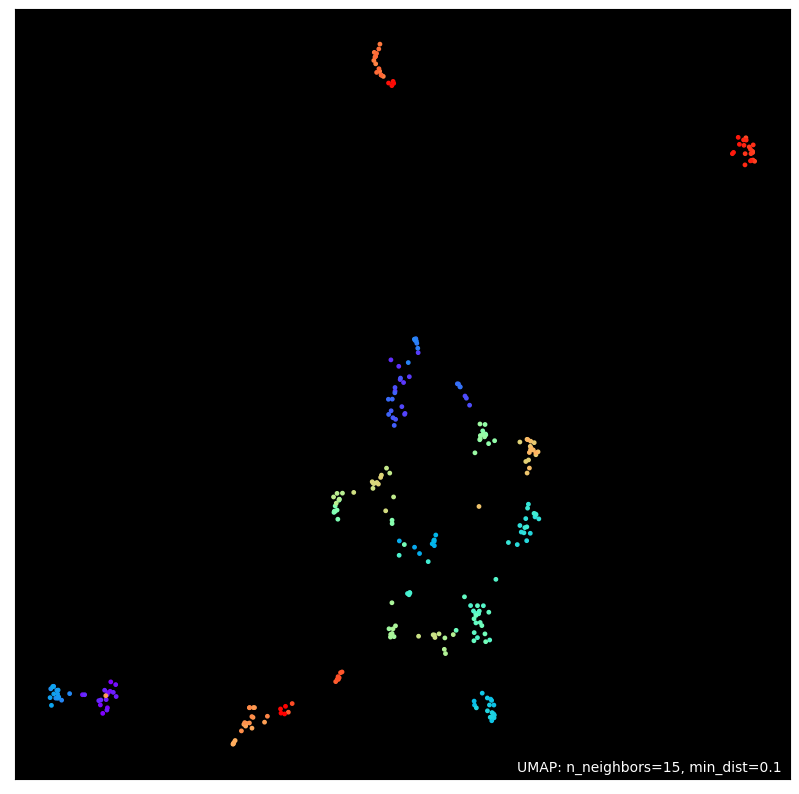

<Figure size 1000x1000 with 1 Axes>

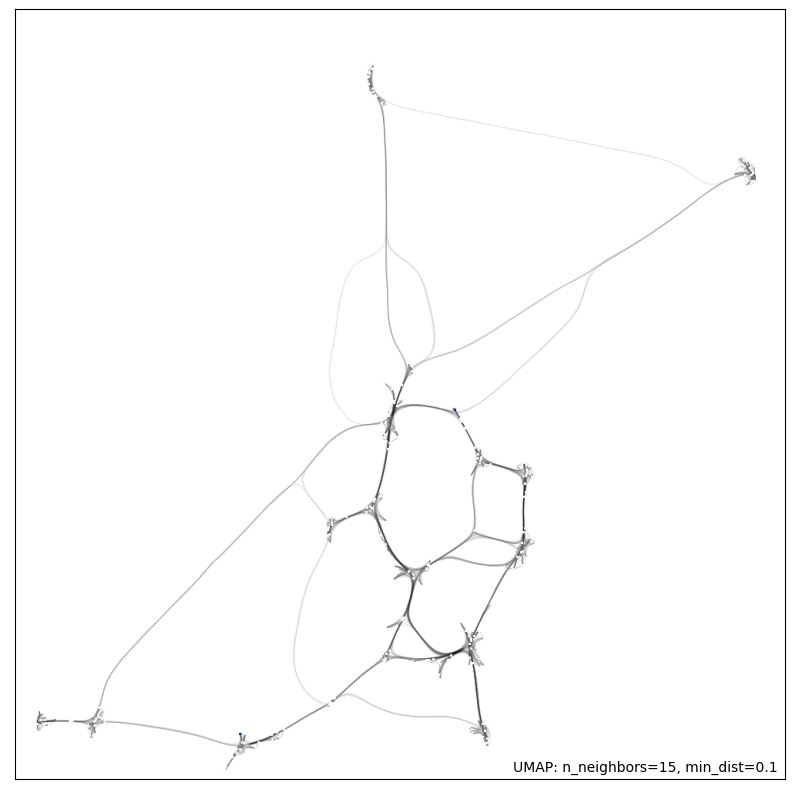

In [ ]:
ml.UMAP(branch_embeddindgs) \
    .plot_clusters(labels=branches) \
    .plot_interactive_clusters(labels=branches) \
    .plot_connectivity()

len(branches)

## Cluster de productos por similitud entre descriptiones

A continuación, se generan embeddings para cada descripción. Luego, se reduce la dimensionalidad para visualizar la distancia entre descripciones deacuerdo a su similitud. Los colores representan las categorias a las que pertenece cada description/producto.

In [ ]:
desc_cat_df = dataset[['description', 'branch']].drop_duplicates()
# desc_cat_df = desc_cat_df.sample(n=10000, random_state=1)

descs  = desc_cat_df['description'].dropna().values
labels = desc_cat_df['branch'].dropna().values

descs.shape, labels.shape

((243188,), (243201,))

In [ ]:
desc_embeddindgs = sentence_encoder(descs)

Batches:   0%|          | 0/7600 [00:00<?, ?it/s]

<model.umap.UMAP object at 0x7f1a34b7a2f0>

<Figure size 1000x1000 with 1 Axes>

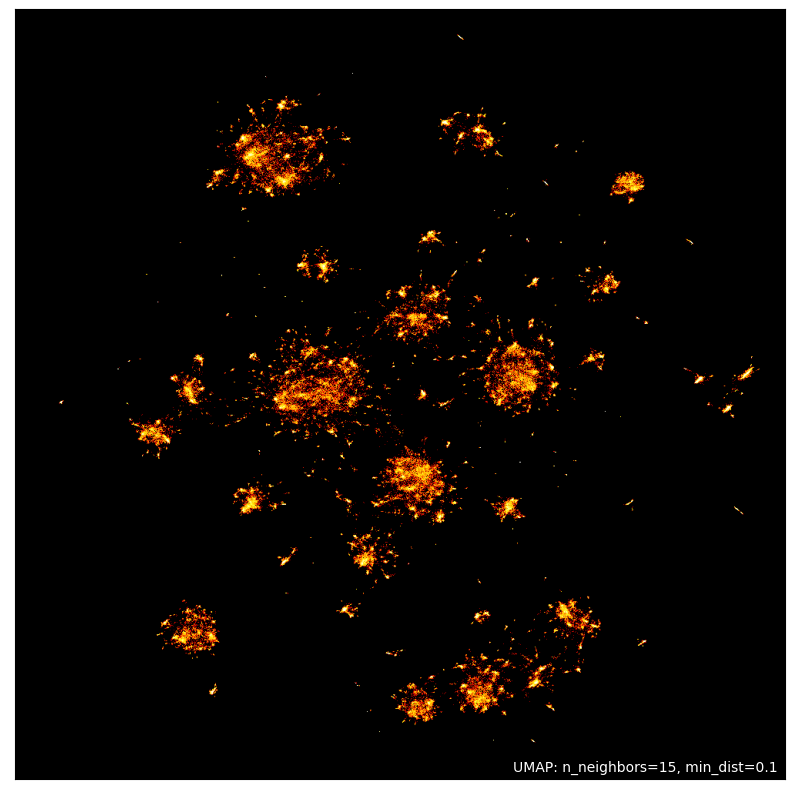

In [ ]:
ml.UMAP(desc_embeddindgs).plot_clusters(labels=None)

#  Description de productos

<Figure size 1500x700 with 1 Axes>

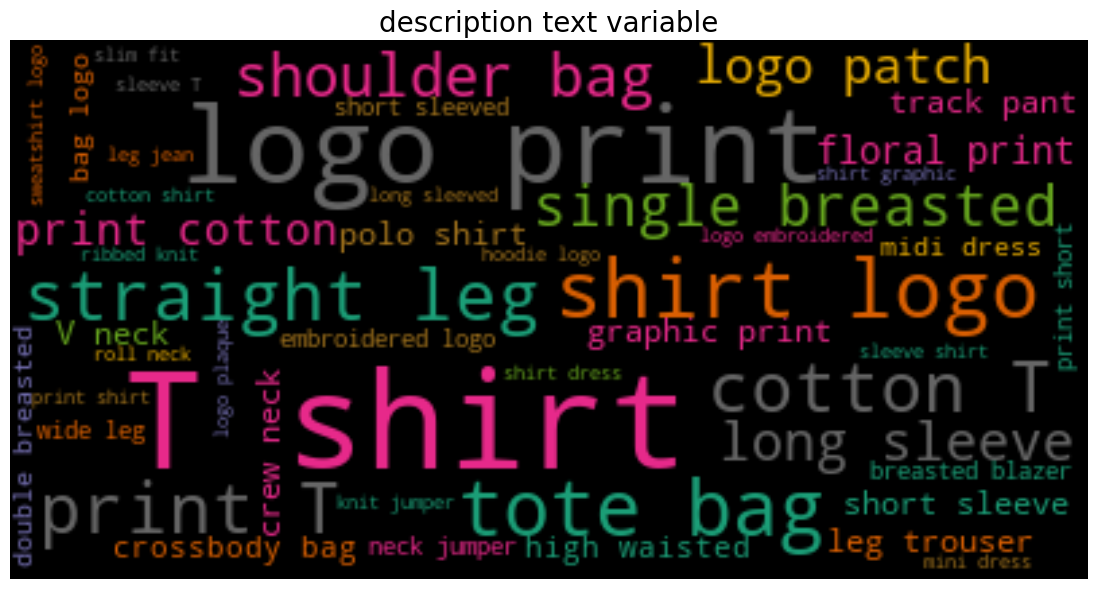

In [29]:
plt.figure(figsize=(15,7))
dataset['description'] = dataset['description'].apply(str)
dt.describe_text_var(dataset, 'description')